# Predicting Resolution Time for Customer Service Data

### By: 
### Yuval Kav 32
### Matan Gin 21

In [3]:
import pandas as pd # tabeles panda
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from tqdm import tqdm
import copy




## Loading the data

In [4]:
customer_ser = pd.read_excel(r".\\customer_service_ai_problem.xlsx")
customer_ser = customer_ser.drop(['Ticket_ID'],axis=1)  #Nuh 

customer_ser.head(3)

,Category,Urgency,Customer_Type,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
0,General Inquiry,Medium,Private,21,4,1,14.38
1,Billing,Low,Business,21,3,0,40.03
2,General Inquiry,High,Private,16,0,0,36.88


In [5]:
customer_ser.head(10)

,Category,Urgency,Customer_Type,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
0,General Inquiry,Medium,Private,21,4,1,14.38
1,Billing,Low,Business,21,3,0,40.03
2,General Inquiry,High,Private,16,0,0,36.88
3,General Inquiry,High,Private,19,4,1,30.14
4,Billing,Low,Business,9,0,0,27.43
5,Billing,High,Private,5,2,0,30.69
6,General Inquiry,High,Business,14,0,1,41.71
7,Technical,Low,Private,21,0,1,24.49
8,General Inquiry,Low,Business,10,0,0,33.06
9,General Inquiry,High,Private,4,3,1,29.94


### Cleaning and Formating

In [6]:
print("Size:",customer_ser.shape,"\n")
#print(customer_ser.columns.values,"\n\n")
customer_ser.info() 

Size: (150, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Category                   150 non-null    object 
 1   Urgency                    150 non-null    object 
 2   Customer_Type              150 non-null    object 
 3   Time_Open_Hour             150 non-null    int64  
 4   Previous_Interactions      150 non-null    int64  
 5   Resolved_By_First_Contact  150 non-null    int64  
 6   Resolution_Time_Minutes    150 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 8.3+ KB


In [7]:
customer_ser.describe()

,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
count,150.000000,150.000000,150.000000,150.000000
mean,11.360000,2.153333,0.446667,36.509533
std,7.293723,1.482500,0.498813,13.583804
min,0.000000,0.000000,0.000000,1.810000
25%,4.000000,1.000000,0.000000,27.442500
50%,11.000000,2.000000,0.000000,35.045000
75%,18.000000,3.000000,1.000000,46.372500
max,23.000000,4.000000,1.000000,70.850000


In [8]:
customer_ser.describe(include="O")


,Category,Urgency,Customer_Type
count,150,150,150
unique,3,3,2
top,General Inquiry,Low,Business
freq,56,51,78


In [9]:
customer_ser["Category"].unique()

array(['General Inquiry', 'Billing', 'Technical'], dtype=object)

In [10]:
for category in customer_ser["Category"].unique():
    print(f"Average resolution time for {category}: ",customer_ser[customer_ser['Category'] == category]['Resolution_Time_Minutes'].mean())

Average resolution time for General Inquiry:  32.31017857142857
Average resolution time for Billing:  30.668750000000003
Average resolution time for Technical:  47.716521739130435


In [11]:
customer_ser["Urgency"] = customer_ser["Urgency"].map({'Low': 0, 'Medium': 1, 'High': 2})

customer_ser["Customer_Type"] = customer_ser["Customer_Type"].map({'Private': 0, 'Business': 1})

customer_ser['Category'] = customer_ser['Category'].map({'Billing': 0, 'General Inquiry': 1, 'Technical': 2})

-------

In [12]:
customer_ser.head()

,Category,Urgency,Customer_Type,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
0,1,1,0,21,4,1,14.38
1,0,0,1,21,3,0,40.03
2,1,2,0,16,0,0,36.88
3,1,2,0,19,4,1,30.14
4,0,0,1,9,0,0,27.43


In [129]:
customer_list = []
column_titles = customer_ser.columns.tolist()
for i,title in enumerate(column_titles):
    print(i,title)
    if title == column_titles[-1]:                             
        time_list = customer_ser[title].to_list()
    else:
        customer_list.append(customer_ser[title].to_list())

print(type(customer_list),len(customer_list))
print(type(customer_list[0]),len(customer_list[0]))
print(type(time_list),len(time_list))


customer_array = np.array(customer_list).T  # (num_samples, num_features)
time_array= np.array(time_list) 

customer_tensor = torch.tensor(customer_array, dtype=torch.float32)  
time_tensor = torch.tensor(time_list, dtype=torch.float32).view(-1, 1)  # Target 

0 Category
1 Urgency
2 Customer_Type
3 Time_Open_Hour
4 Previous_Interactions
5 Resolved_By_First_Contact
6 Resolution_Time_Minutes
<class 'list'> 6
<class 'list'> 150
<class 'list'> 150


### Plot functions

In [14]:
def plot_prediction_band(actual_time , predicted_time,error_allowed = 5):   

    plt.figure(figsize=(6, 6))
    plt.scatter(actual_time, predicted_time, color='red', label='Predicted')
    plt.plot([min(actual_time), max(actual_time)],[min(actual_time), max(actual_time)], linestyle='--', label='Perfect ')  # y=x...

    min_val = min(actual_time)
    max_val = max(actual_time)
    plt.plot([min_val,max_val],[min_val + error_allowed,max_val + error_allowed],linestyle=':',color='lime',label=f'+{error_allowed} min margin')
    plt.plot([min_val,max_val],[min_val - error_allowed,max_val - error_allowed],linestyle=':',color='lime',label=f'-{error_allowed} min margin')

    plt.xlabel("Actual Time")
    plt.ylabel("Predicted Time")
    plt.title("Predicted Time vs Actual Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def plot_train_val(loss_train,loss_val):

    plt.figure(figsize=(10, 5))
    plt.plot(loss_train,label='TrainY')
    plt.plot(loss_val,color="lime",label='VALY')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

# Testing diffrent regressions

In [16]:
customer_train, customer_val, time_train, time_val = train_test_split(customer_tensor,time_tensor,test_size=0.2,random_state=42) # Tensors for Neural Net

print(customer_train.shape,customer_val.shape)  
print(time_train.shape,time_val.shape)      

torch.Size([120, 6]) torch.Size([30, 6])
torch.Size([120, 1]) torch.Size([30, 1])


## Neural Networks


### single layer NN

In [17]:
class single_layer_NN(nn.Module):
    def __init__(self,input_layer=6,hidden_layer=64):
        super(single_layer_NN, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, 1)                     # finale num         

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                                             
        return x


In [ ]:
model = single_layer_NN()
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [18]:
def training_NN(customer_train,time_train,customer_val,time_val,model,criterion,optimizer,scheduler=None,epochs=1000,layers=1):
    best_val_loss = 1000
    loss_train = []
    loss_val = []
    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()       
        predicted = model(customer_train)          
        loss = criterion(predicted, time_train)  
        loss.backward()            
        optimizer.step()      

        loss_train.append(loss.item())  

        model.eval()
        with torch.no_grad():
            val_predictions = model(customer_val)
            val_loss = criterion(val_predictions, time_val)
            if scheduler != None:
                scheduler.step(val_loss)
            loss_val.append(val_loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], val Loss: {val_loss.item():.4f},  train loss: {loss}")              # if we want to print...
        
        if len(loss_val)< 3 :
            pass
        elif val_loss < best_val_loss:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_val': val_loss,
                'loss_train': loss
            }, f'models/{layers}-layer-NN.pth')
            best_val_loss = val_loss

    return model,loss_train,loss_val,best_val_loss

In [20]:
def success_rate_tensors(time_pred_squze,time_real_squze,error_allowed=5):

    if len(time_real_squze.shape) > 1:                # in case of this dangerous case.
        time_real_squze = time_real_squze.squeeze()
    if len(time_pred_squze.shape) > 1:                
        time_pred_squze = time_pred_squze.squeeze()

    differences = torch.abs(time_pred_squze - time_real_squze)
    success_count = torch.sum(differences <= error_allowed).item()
    total = len(time_real_squze)

    success_rate = success_count / total * 100

    return success_rate,success_count,total

### HyperParameters tuning:

In [ ]:
# Hyperparameter options
learning_rates = [1e-3,1e-4]
hidden_sizes = [8,16,32,64]
epochs = [2500,5000]
weight_dec = [0,1e-4,1e-5,1e-3]


best_success = 0
best_params = None
best_model = None
best_train = None
best_val = None

param_grid = list(itertools.product(learning_rates, hidden_sizes, epochs,weight_dec))


for i, (lr, hidden, ep,wd) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):
   
    #print(f"Training with lr={lr}, hidden_size={hidden}, epochs={ep}")

    loss_train = []
    loss_val = []

    model = single_layer_NN(input_layer=6, hidden_layer=hidden)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=100,threshold=1e-4)
    for epoch in range(ep):
        model.train()
        optimizer.zero_grad()
        outputs = model(customer_train)
        loss = criterion(outputs, time_train)
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())  

        model.eval()
        with torch.no_grad():       
            val_outputs = model(customer_val)
            val_loss = criterion(val_outputs, time_val) 
            loss_val.append(val_loss.item())                #calc val loss as well....
            # scheduler.step(val_loss)
            

    model.eval()
    with torch.no_grad():
        predictions = model(customer_val).squeeze()  # n_samples

    success_rate,success_count,total = success_rate_tensors(predictions,time_val)

    if success_rate > best_success:
        best_success = success_rate
        best_params = {'learning_rate': lr, 'hidden_size': hidden, 'epochs': ep , 'weight_dec' : wd}
        best_model = copy.deepcopy(model)
        best_train = loss_train[:]
        best_val = loss_val[:]


print(f"\nBest success: {best_success:.1f}% with params: {best_params}")


Grid Search: 100%|██████████| 64/64 [03:30<00:00,  3.28s/it]


Best success: 73.3% with params: {'learning_rate': 0.001, 'hidden_size': 64, 'epochs': 5000, 'weight_dec': 0.001}


In [ ]:
model = single_layer_NN(hidden_layer=64)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.9,patience=100,threshold=1e-4,min_lr=1e-4)
model,loss_train,loss_val,best_val_loss = training_NN(customer_train,
                                                         time_train,
                                                         customer_val,
                                                         time_val,
                                                         model=model
                                                         ,criterion=criterion
                                                         ,optimizer=optimizer,
                                                         scheduler=scheduler,
                                                         epochs=10000)

Epoch [50/10000], val Loss: 1068.6221,  train loss: 977.6765747070312
Epoch [100/10000], val Loss: 659.1019,  train loss: 557.2705078125
Epoch [150/10000], val Loss: 424.4860,  train loss: 335.5921325683594
Epoch [200/10000], val Loss: 351.7963,  train loss: 269.6459045410156
Epoch [250/10000], val Loss: 295.5120,  train loss: 214.99815368652344
Epoch [300/10000], val Loss: 249.0158,  train loss: 172.4368438720703
Epoch [350/10000], val Loss: 212.3802,  train loss: 140.90696716308594
Epoch [400/10000], val Loss: 184.9623,  train loss: 119.44853973388672
Epoch [450/10000], val Loss: 164.3011,  train loss: 105.74051666259766
Epoch [500/10000], val Loss: 148.0186,  train loss: 96.17081451416016
Epoch [550/10000], val Loss: 135.5903,  train loss: 89.50466918945312
Epoch [600/10000], val Loss: 125.1414,  train loss: 84.34033966064453
Epoch [650/10000], val Loss: 116.0715,  train loss: 80.11675262451172
Epoch [700/10000], val Loss: 108.2604,  train loss: 76.57621002197266
Epoch [750/10000], 


Finale Loss: 50.765445709228516
best loss: 40.82950973510742


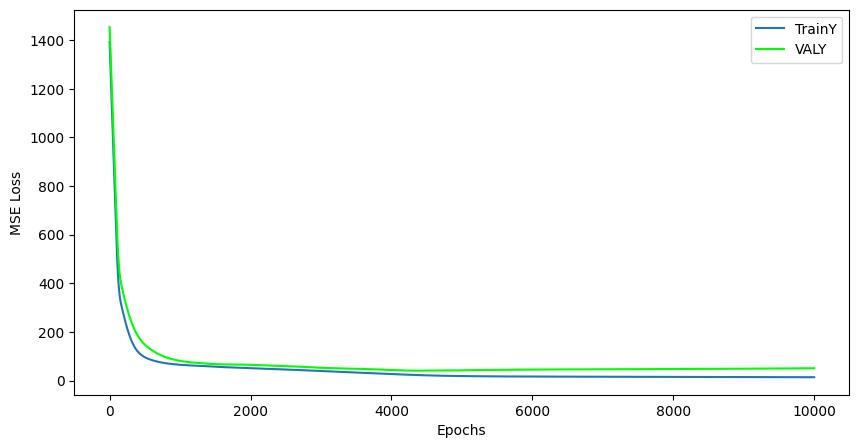

In [ ]:
print(f"\nFinal Loss: {loss_val[-1]}")
print(f"best loss: {best_val_loss}")
plot_train_val(loss_train,loss_val)


In [359]:
model = single_layer_NN(hidden_layer=64)
checkpoint = torch.load('models/1-layer-NN_73.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
saved_val_loss = checkpoint['loss_val']
saved_train_loss = checkpoint['loss_train']
model.eval() 

single_layer_NN(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [361]:
model.eval()
with torch.no_grad():
    predictions = model(customer_val).squeeze()  # n_samples

success_rate,success_count,total = success_rate_tensors(predictions,time_val)

print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {saved_val_loss} , train mse loss: {saved_train_loss}")
# print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30})")



 Success ±5 min: 73.33% (22/30) , MSE val loss : 40.82950973510742 , train mse loss: 22.499258041381836


This graph plots the predicted time and actual time similar to a confusion matrix. <br>
The ideal graph would be the dotted line since it means the actual time is equal to the predicted time

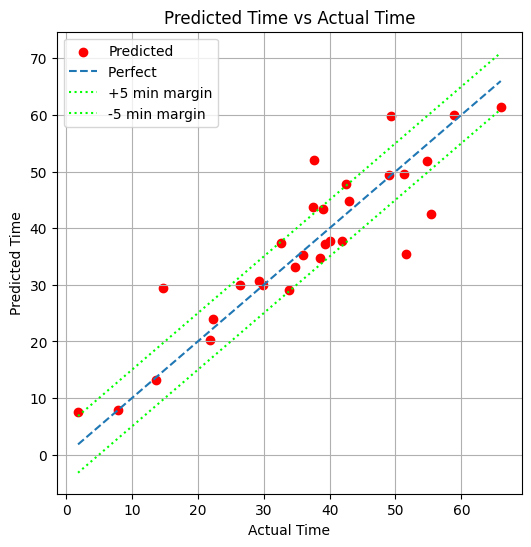

In [363]:
plot_prediction_band(time_val , predictions)

-------

# Testing diffrent structures

In [96]:
class double_layer_NN(nn.Module):
    def __init__(self, input_layer=6, hidden_layer=32):
        super(double_layer_NN, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, hidden_layer)        #added hidden layer
        self.fc3 = nn.Linear(hidden_layer, 1)                           

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                                             
        return x

### HyperParameter tuning

In [269]:
learning_rates = [1e-3, 1e-4]
hidden_sizes = [8,16, 32,64]
epochs = [2500,5000]
weight_dec = [0,1e-4,1e-5,1e-3]

best_success = 0
best_params = None
best_model_sec = None
best_train_sec = None
best_val_sec = None

param_grid = list(itertools.product(learning_rates, hidden_sizes, epochs,weight_dec))

for i, (lr, hidden, ep,wd) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):

    loss_train = []
    loss_val = []

    model = double_layer_NN(input_layer=6, hidden_layer=hidden)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=10,threshold=1e-4)
    for epoch in range(ep):
        model.train()
        optimizer.zero_grad()
        outputs = model(customer_train)
        loss = criterion(outputs, time_train)
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())  

        model.eval()
        with torch.no_grad():       
            val_outputs = model(customer_val)
            val_loss = criterion(val_outputs, time_val) 
            loss_val.append(val_loss.item()) 
            # scheduler.step(val_loss)               


    model.eval()
    with torch.no_grad():
        predictions = model(customer_val).squeeze()  # n_samples

    success_rate,success_count,total = success_rate_tensors(predictions,time_val)

    if success_rate > best_success:
        best_success = success_rate
        best_params = {'learning_rate': lr, 'hidden_size': hidden, 'epochs': ep, 'weight_dec' : wd}
        best_model_sec = copy.deepcopy(model)
        best_train_sec = loss_train[:]
        best_val_sec = loss_val[:]

        

print(f"\nBest success: {best_success:.4f} with params: {best_params}")


Grid Search: 100%|██████████| 64/64 [05:15<00:00,  4.93s/it]


Best success: 60.0000 with params: {'learning_rate': 0.001, 'hidden_size': 32, 'epochs': 2500, 'weight_dec': 0.0001}


In [ ]:
model = double_layer_NN(hidden_layer=32)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.9,patience=100,threshold=1e-4,min_lr=1e-4)
model,loss_train,loss_val,best_val_loss = training_NN(customer_train,
                                                         time_train,
                                                         customer_val,
                                                         time_val,
                                                         model=model
                                                         ,criterion=criterion
                                                         ,optimizer=optimizer,
                                                        #  scheduler=scheduler,
                                                         epochs=10000,
                                                         layers=2)

Epoch [50/10000], val Loss: 1251.2817,  train loss: 1184.8341064453125
Epoch [100/10000], val Loss: 507.3025,  train loss: 436.8026123046875
Epoch [150/10000], val Loss: 226.1718,  train loss: 166.53866577148438
Epoch [200/10000], val Loss: 157.1385,  train loss: 107.12161254882812
Epoch [250/10000], val Loss: 131.2350,  train loss: 89.10452270507812
Epoch [300/10000], val Loss: 115.0022,  train loss: 80.22571563720703
Epoch [350/10000], val Loss: 102.2655,  train loss: 73.80177307128906
Epoch [400/10000], val Loss: 91.9805,  train loss: 68.76701354980469
Epoch [450/10000], val Loss: 83.5469,  train loss: 64.68672943115234
Epoch [500/10000], val Loss: 76.9756,  train loss: 61.402828216552734
Epoch [550/10000], val Loss: 71.7177,  train loss: 58.67960739135742
Epoch [600/10000], val Loss: 67.6472,  train loss: 56.654884338378906
Epoch [650/10000], val Loss: 64.6469,  train loss: 55.096435546875
Epoch [700/10000], val Loss: 62.6453,  train loss: 53.93045425415039
Epoch [750/10000], val L


Final Loss: 94.72006225585938
best loss: 37.28184509277344


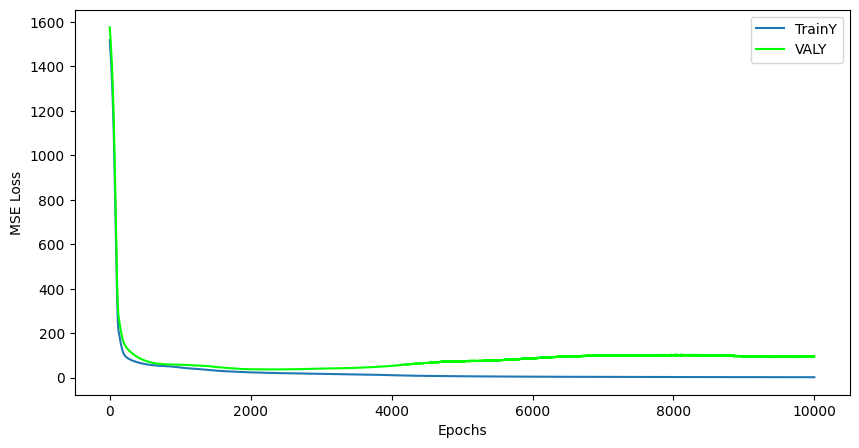

In [278]:
print(f"\nFinal Loss: {loss_val[-1]}")
print(f"best loss: {best_val_loss}")
plot_train_val(loss_train,loss_val)


In [370]:
model = double_layer_NN(hidden_layer=32)
checkpoint = torch.load('models/2-layer-NN_70.pth')

model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']
saved_val_loss = checkpoint['loss_val']
saved_train_loss = checkpoint['loss_train']
model.eval() 

double_layer_NN(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [371]:
model.eval()
with torch.no_grad():
    predictions = model(customer_val).squeeze()  # n_samples

success_rate,success_count,total = success_rate_tensors(predictions,time_val)

print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {saved_val_loss} , train mse loss: {saved_train_loss}")
# print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30})")



 Success ±5 min: 70.00% (21/30) , MSE val loss : 37.28184509277344 , train mse loss: 21.854196548461914


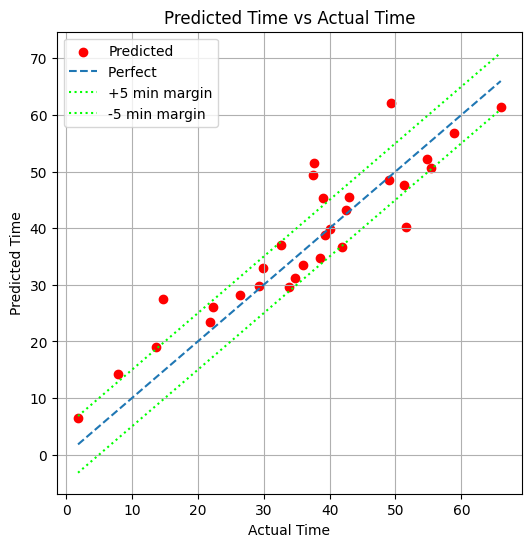

In [372]:
plot_prediction_band(time_val , predictions)

---

---

# SVR

#### Support Vector Regression

In [130]:
customer_train_reg, customer_val_reg, time_train_reg, time_val_reg = train_test_split(customer_array, time_array, test_size=0.2, random_state=42)


In [22]:
def svr_regression(customer_train_reg,time_train_reg, kernal = "rbf",C=1.0, epsilon=1, gamma='scale'):
    svr = SVR(kernel=kernal, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(customer_train_reg, time_train_reg)
    
    return svr

In [23]:
def success_rate_nparray(time_pred,time_real,error_allowed=5):

    time_pred = np.squeeze(time_pred)         # squeeze because sometimes our array become (n,1) which crashes the code          
    time_real = np.squeeze(time_real)

    differences = np.abs(time_pred - time_real)
    success_count = np.sum(differences <= error_allowed)
    total = len(time_real)
    success_rate = success_count / total * 100

    return success_rate,success_count,total

### HyperParameter tuning

In [24]:
customer_train_reg, customer_val_reg, time_train_reg, time_val_reg = train_test_split(customer_array, time_array, test_size=0.2, random_state=42)

kernel = ['rbf', 'linear','sigmoid']          # Since 'poly' is heavy :\
C = [0.1, 1, 10, 100,1000]
epsilon= [0.5 ,1, 3,5]
gamma = ['scale', 'auto', 0.1, 1, 0.01]


best_success = 0
best_params = None
best_model_sec = None
best_train_sec = None
best_val_sec = None

param_grid = list(itertools.product(kernel, C, epsilon, gamma))

scalled_customer_train_reg = StandardScaler()                                               #all have the same scale...        
customer_train_reg = scalled_customer_train_reg.fit_transform(customer_train_reg)
customer_val_reg = scalled_customer_train_reg.transform(customer_val_reg)   #same scalling...

for i, (ker, C, epsilon, gamma) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):

    curr_model = svr_regression(customer_train_reg,time_train_reg,ker,C, epsilon,gamma)

    pred_train = curr_model.predict(customer_train_reg)
    mse_train = mean_squared_error(time_train_reg, pred_train)

    predictions = curr_model.predict(customer_val_reg)  # n_samples
    mse_val = mean_squared_error(time_val_reg, predictions)

    success_rate,success_count,total = success_rate_nparray(predictions,time_val_reg)

  
    #print(f"{i} : Training with ker={ker}, CC={CC}, gamma={gamma}, epsilon={epsilon} ---> Success: {best_success:.2f}")
    if best_success < success_rate : 
        best_success = success_rate
        best_params = {'kernel': ker, 'C': C, 'epsilon': epsilon, 'gamma' : gamma}
        best_model_third = copy.deepcopy(curr_model)
        best_train_third = mse_train
        best_val_third = mse_val


print(f"\nBest success: {best_success:.4f} with params: {best_params}")
print(f"Train loss: {best_train_third}, Val loss: {best_val_third}")

Grid Search: 100%|██████████| 300/300 [00:01<00:00, 158.77it/s]


Best success: 53.3333 with params: {'kernel': 'rbf', 'C': 100, 'epsilon': 1, 'gamma': 0.1}
Train loss: 13.621756961329886, Val loss: 55.740192794923026


In [25]:
model = svr_regression(customer_train_reg,time_train_reg,
                       kernal='rbf',
                       C=100,
                       epsilon = 1,
                       gamma = 0.1)

In [26]:
predictions = model.predict(customer_val_reg)  # n_samples

pred_train = model.predict(customer_train_reg)
loss_train = mean_squared_error(time_train_reg, pred_train)

predictions = model.predict(customer_val_reg)  # n_samples
loss_val = mean_squared_error(time_val_reg, predictions)
success_rate,success_count,total = success_rate_nparray(predictions,time_val_reg)

print(f"\n Success ±5 sec: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {loss_val} , train mse loss: {loss_train}")


 Success ±5 sec: 53.33% (16/30) , MSE val loss : 55.740192794923026 , train mse loss: 13.621756961329886


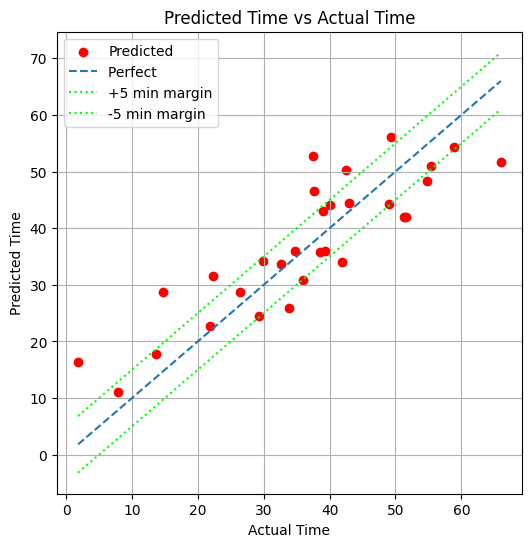

In [27]:
plot_prediction_band(time_val_reg , predictions)

----

## Linear Regression

In [131]:
customer_train_reg, customer_val_reg, time_train_reg, time_val_reg = train_test_split(customer_array, time_array, test_size=0.2, random_state=42)

print(type(customer_train_reg),type(time_train_reg))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>



 Success ±5 sec: 40.00% (12/30),  MSE:73.87995887304072


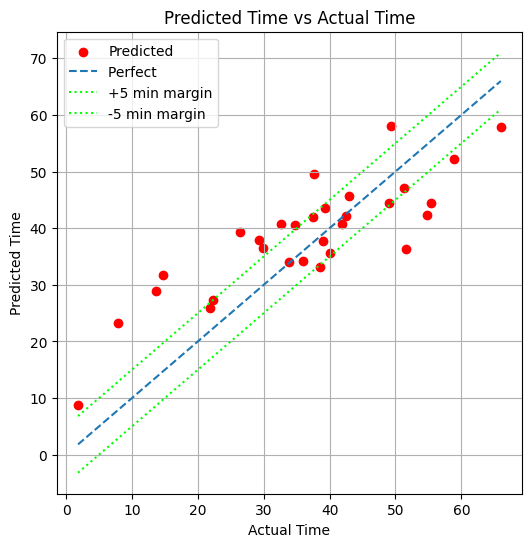

In [29]:
reg = LinearRegression().fit(customer_train_reg,time_train_reg)

time_pred_val = reg.predict(customer_val_reg)

differences = np.abs(time_pred_val - time_val_reg)

success_count = np.sum(differences <= 5)
total = len(time_val_reg)

success_rate = success_count / total * 100

mse = mean_squared_error(time_val_reg, time_pred_val)

print(f"\n Success ±5 sec: {success_rate:.2f}% ({success_count}/{total}),  MSE:{mse}")

plot_prediction_band(time_val_reg,time_pred_val)

---

## Polynomial Regression

In [30]:
customer_list = []
column_titles = customer_ser.columns.tolist()
for i,title in enumerate(column_titles):

    if i == len(column_titles) - 1:                             
        time_list = customer_ser[title].to_list()
    else:
        customer_list.append(customer_ser[title].to_list())

customer_array = np.array(customer_list).T  # (num_samples, num_features)
time_array= np.array(time_list) 

customer_tensor = torch.tensor(customer_array, dtype=torch.float32)  
time_tensor = torch.tensor(time_list, dtype=torch.float32).view(-1, 1)  # Target 

In [31]:
correlation_matrix = customer_ser.corr(numeric_only=True)
print(correlation_matrix)

                           Category   Urgency  Customer_Type  Time_Open_Hour  \
Category                   1.000000 -0.112354      -0.016185       -0.087224   
Urgency                   -0.112354  1.000000      -0.048546        0.055607   
Customer_Type             -0.016185 -0.048546       1.000000       -0.016668   
Time_Open_Hour            -0.087224  0.055607      -0.016668        1.000000   
Previous_Interactions      0.064453  0.038301      -0.080919       -0.074035   
Resolved_By_First_Contact  0.099845  0.048785      -0.103070       -0.092457   
Resolution_Time_Minutes    0.495143  0.257612       0.207789       -0.006760   

                           Previous_Interactions  Resolved_By_First_Contact  \
Category                                0.064453                   0.099845   
Urgency                                 0.038301                   0.048785   
Customer_Type                          -0.080919                  -0.103070   
Time_Open_Hour                         -0.0

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(customer_array)

# Optional: get the new feature names
feature_names = poly.get_feature_names_out(input_features=column_titles[:-1])
print(feature_names)

['Category' 'Urgency' 'Customer_Type' 'Time_Open_Hour'
 'Previous_Interactions' 'Resolved_By_First_Contact' 'Category^2'
 'Category Urgency' 'Category Customer_Type' 'Category Time_Open_Hour'
 'Category Previous_Interactions' 'Category Resolved_By_First_Contact'
 'Urgency^2' 'Urgency Customer_Type' 'Urgency Time_Open_Hour'
 'Urgency Previous_Interactions' 'Urgency Resolved_By_First_Contact'
 'Customer_Type^2' 'Customer_Type Time_Open_Hour'
 'Customer_Type Previous_Interactions'
 'Customer_Type Resolved_By_First_Contact' 'Time_Open_Hour^2'
 'Time_Open_Hour Previous_Interactions'
 'Time_Open_Hour Resolved_By_First_Contact' 'Previous_Interactions^2'
 'Previous_Interactions Resolved_By_First_Contact'
 'Resolved_By_First_Contact^2']


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_poly, time_array, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

predictions = reg.predict(X_val)

mse = mean_squared_error(y_val, predictions)
print(f"MSE: {mse:.2f}")

differences = np.abs(predictions - y_val)
success_count = np.sum(differences <= 5)
success_rate = success_count / len(y_val) * 100
print(f"Success ±5 sec: {success_rate:.2f}% ({success_count}/{len(y_val)})")

MSE: 35.27
Success ±5 sec: 56.67% (17/30)


In [34]:
print(type(poly))


<class 'sklearn.preprocessing._polynomial.PolynomialFeatures'>


------------------------

# Over sampling

#### Our data is really tricky since all parameters are discrete except the target parameter.
#### This means we cant use most widespread techniques of over samplings and there is not guarantee that our oversampling will be correct

##### CTGAN is a type of generative model that uses deep learning to create synthetic tabular data.

##### It's designed to learn the underlying patterns and structure of real data and generate new, synthetic data that resembles the original.



In [35]:
from ctgan import CTGAN


In [43]:
ctgan = CTGAN(epochs=3000, verbose=True)

discrete_columns = ['Category', 'Urgency', 'Customer_Type', 'Resolved_By_First_Contact','Time_Open_Hour','Previous_Interactions']
ctgan.fit(customer_ser, discrete_columns)

synthetic_data = ctgan.sample(1000)


Gen. (-0.62) | Discrim. (-0.03): 100%|██████████| 3000/3000 [01:32<00:00, 32.47it/s]


In [37]:
print(type(synthetic_data),synthetic_data.shape)

<class 'pandas.core.frame.DataFrame'> (1000, 7)


### We will compare the datasets to see if our oversampling worked on our discrete data

In [41]:
customer_ser.describe()

,Category,Urgency,Customer_Type,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.986667,1.000000,0.520000,11.360000,2.153333,0.446667,36.509533
std,0.794162,0.827384,0.501274,7.293723,1.482500,0.498813,13.583804
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.810000
25%,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,27.442500
50%,1.000000,1.000000,1.000000,11.000000,2.000000,0.000000,35.045000
75%,2.000000,2.000000,1.000000,18.000000,3.000000,1.000000,46.372500
max,2.000000,2.000000,1.000000,23.000000,4.000000,1.000000,70.850000


In [42]:
synthetic_data.describe()

,Category,Urgency,Customer_Type,Time_Open_Hour,Previous_Interactions,Resolved_By_First_Contact,Resolution_Time_Minutes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,0.785000,0.907000,0.581000,11.165000,1.97500,0.540000,36.687807
std,0.825504,0.832493,0.493642,7.039412,1.56679,0.498647,14.335169
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.706274
25%,0.000000,0.000000,0.000000,4.000000,0.00000,0.000000,26.616328
50%,1.000000,1.000000,1.000000,11.000000,2.00000,1.000000,36.225300
75%,2.000000,2.000000,1.000000,18.000000,3.00000,1.000000,46.610113
max,2.000000,2.000000,1.000000,23.000000,4.00000,1.000000,78.964378


In [40]:
customer_list = []
syn_costumer_list = []
column_titles = customer_ser.columns.tolist()
for i, title in enumerate(column_titles):
    if i == len(column_titles) - 1:
        syn_time_list = synthetic_data[title].to_list()
    else:
        syn_costumer_list.append(synthetic_data[title].to_list())


syn_costumer_array = np.array(syn_costumer_list).T  
syn_time_array = np.array(syn_time_list)


syn_customer_tensor = torch.tensor(syn_costumer_array, dtype=torch.float32)
syn_time_tensor = torch.tensor(syn_time_array, dtype=torch.float32).view(-1, 1)  # Target

syn_customer_train, syn_customer_val, syn_time_train, syn_time_val = train_test_split(syn_customer_tensor, syn_time_tensor, test_size=0.2, random_state=42) 


combined_time_train = torch.cat((time_train, syn_time_train), dim=0)


print(syn_customer_train.shape, syn_customer_val.shape)  
print(syn_time_train.shape, syn_time_val.shape)
  

torch.Size([800, 6]) torch.Size([200, 6])
torch.Size([800, 1]) torch.Size([200, 1])


### Testing different models on the oversampled data

### 1-layer NN

In [45]:
# Hyperparameter options
learning_rates = [1e-3]
hidden_sizes = [16,32,64,128]
epochs = [2500,5000]
weight_dec = [0,1e-4,1e-3]
precent = [0.5,0.75]

best_success = 0
best_params = None
best_model = None
best_train = None
best_val = None
best_val_syn = None
best_success_syn= None

param_grid = list(itertools.product(learning_rates, hidden_sizes, epochs,weight_dec,precent))


for i, (lr, hidden, ep,wd,precen) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):
   
    #print(f"Training with lr={lr}, hidden_size={hidden}, epochs={ep}")

    loss_train = []
    loss_val = []
    loss_val_syn = []

    model = single_layer_NN(input_layer=6, hidden_layer=hidden)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd)

    for epoch in range(ep):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(customer_train)
        loss = criterion(outputs, time_train)
        outputs_syn = model(syn_customer_train)
        loss_syn = criterion(outputs_syn, syn_time_train)
        loss_total = precen*loss + (1-precen)*loss_syn

        loss_total.backward()
        optimizer.step()
        loss_train.append(loss_total.item())


        model.eval()
        with torch.no_grad():       
            val_outputs = model(customer_val)
            val_loss = criterion(val_outputs, time_val) 
            loss_val.append(val_loss.item())                #calc val loss as well....

            val_outputs_syn = model(syn_customer_val)
            val_loss_syn = criterion(val_outputs_syn, syn_time_val) 
            loss_val_syn.append(val_loss_syn.item()) 

    model.eval()
    with torch.no_grad():
        predictions = model(customer_val).squeeze()  # n_samples
        predictions_syn = model(syn_customer_val).squeeze() 


    success_rate,success_count,total = success_rate_tensors(predictions,time_val)
    success_rate_syn,success_count_syn,total_syn = success_rate_tensors(predictions_syn,syn_time_val)

    if success_rate > best_success:         #whats importnat is val form original.
        best_success = success_rate
        best_params = {'learning_rate': lr, 'hidden_size': hidden, 'epochs': ep , 'weight_dec' : wd, 'precent' : precen}
        best_model = copy.deepcopy(model)
        best_train = loss_train[:]
        best_val = loss_val[:]
        best_val_syn = loss_val_syn[:]
        best_success_syn = success_rate_syn

print(f"\nBest success: {best_success:.1f}% , success for syn data val: {best_success_syn}%  with params: {best_params}")

Grid Search: 100%|██████████| 48/48 [05:53<00:00,  7.37s/it]


Best success: 56.7% , success for syn data val: 28.000000000000004%  with params: {'learning_rate': 0.001, 'hidden_size': 32, 'epochs': 5000, 'weight_dec': 0.001, 'precent': 0.75}


In [88]:
torch.save({
                'epoch': epoch,
                'model_state_dict': best_model.state_dict(),
                'loss_val': best_val,
                'loss_train': best_train
            }, f'models/1-layer-NN_oversample_56.pth')

In [90]:
model = single_layer_NN(hidden_layer=32)
checkpoint = torch.load('models/1-layer-NN_oversample_56.pth')

model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']
saved_val_loss = checkpoint['loss_val']
saved_train_loss = checkpoint['loss_train']
model.eval() 

single_layer_NN(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [91]:
model.eval()
with torch.no_grad():
    predictions = model(customer_val).squeeze()  # n_samples
success_rate,success_count,total = success_rate_tensors(predictions,time_val)

print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {saved_val_loss[-1]} , train mse loss: {saved_train_loss[-1]}")
# print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30})")



 Success ±5 min: 56.67% (17/30) , MSE val loss : 50.544898986816406 , train mse loss: 64.748046875


This graph plots the predicted time and actual time similar to a confusion matrix. <br>
The ideal graph would be the dotted line since it means the actual time is equal to the predicted time


Final: Loss: 50.544898986816406


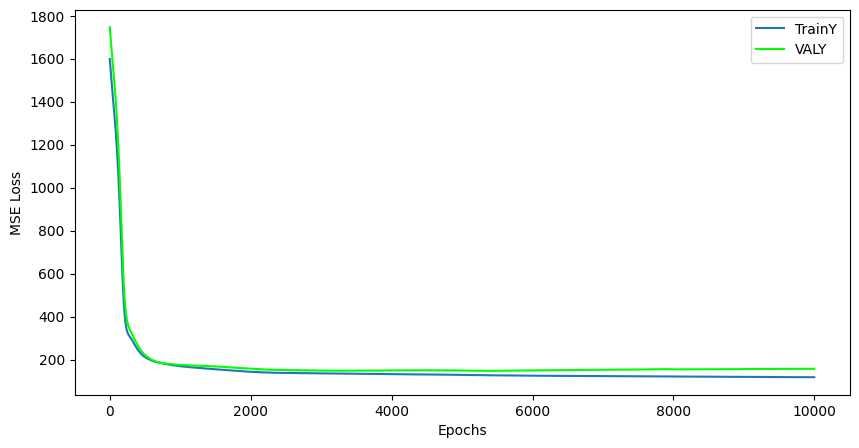

best val loss: 147.1039581298828


In [92]:
print(f"\nFinal: Loss: {best_val[-1]}")
plot_train_val(loss_train,loss_val)
print(f"best val loss: {best_val_loss}")

c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


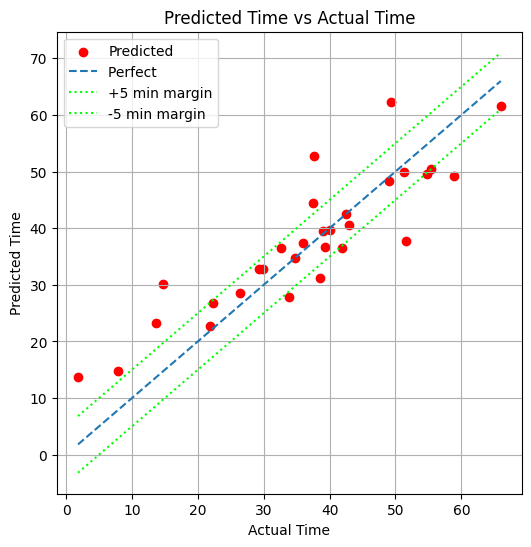

In [93]:
plot_prediction_band(time_val , predictions)

### 2-layer NN

In [97]:
# Hyperparameter options
learning_rates = [1e-3]
hidden_sizes = [16,32,64]
epochs = [2500,5000]
weight_dec = [0,1e-4,1e-3]
precent = [0.5,0.75]

best_success = 0
best_params = None
best_model = None
best_train = None
best_val = None
best_val_syn = None
best_success_syn= None

param_grid = list(itertools.product(learning_rates, hidden_sizes, epochs,weight_dec,precent))


for i, (lr, hidden, ep,wd,precen) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):
   
    #print(f"Training with lr={lr}, hidden_size={hidden}, epochs={ep}")

    loss_train = []
    loss_val = []
    loss_val_syn = []

    model = double_layer_NN(input_layer=6, hidden_layer=hidden)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd)

    for epoch in range(ep):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(customer_train)
        loss = criterion(outputs, time_train)
        outputs_syn = model(syn_customer_train)
        loss_syn = criterion(outputs_syn, syn_time_train)
        loss_total = precen*loss + (1-precen)*loss_syn

        loss_total.backward()
        optimizer.step()
        loss_train.append(loss_total.item())


        model.eval()
        with torch.no_grad():       
            val_outputs = model(customer_val)
            val_loss = criterion(val_outputs, time_val) 
            loss_val.append(val_loss.item())                #calc val loss as well....

            val_outputs_syn = model(syn_customer_val)
            val_loss_syn = criterion(val_outputs_syn, syn_time_val) 
            loss_val_syn.append(val_loss_syn.item()) 

    model.eval()
    with torch.no_grad():
        predictions = model(customer_val).squeeze()  # n_samples
        predictions_syn = model(syn_customer_val).squeeze() 


    success_rate,success_count,total = success_rate_tensors(predictions,time_val)
    success_rate_syn,success_count_syn,total_syn = success_rate_tensors(predictions_syn,syn_time_val)

    if success_rate > best_success:         #whats importnat is val form original.
        best_success = success_rate
        best_params = {'learning_rate': lr, 'hidden_size': hidden, 'epochs': ep , 'weight_dec' : wd, 'precent' : precen}
        best_model = copy.deepcopy(model)
        best_train = loss_train[:]
        best_val = loss_val[:]
        best_val_syn = loss_val_syn[:]
        best_success_syn = success_rate_syn

print(f"\nBest success: {best_success:.1f}% , success for syn data val: {best_success_syn}%  with params: {best_params}")

Grid Search: 100%|██████████| 36/36 [06:46<00:00, 11.28s/it]


Best success: 60.0% , success for syn data val: 27.500000000000004%  with params: {'learning_rate': 0.001, 'hidden_size': 16, 'epochs': 5000, 'weight_dec': 0.001, 'precent': 0.75}


In [98]:
torch.save({
                'epoch': epoch,
                'model_state_dict': best_model.state_dict(),
                'loss_val': best_val,
                'loss_train': best_train
            }, f'models/2-layer-NN_oversample_60.pth')

In [101]:
model = double_layer_NN(hidden_layer=16)
checkpoint = torch.load('models/2-layer-NN_oversample_60.pth')

model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']
saved_val_loss = checkpoint['loss_val']
saved_train_loss = checkpoint['loss_train']
model.eval() 

double_layer_NN(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [102]:
model.eval()
with torch.no_grad():
    predictions = model(customer_val).squeeze()  # n_samples
success_rate,success_count,total = success_rate_tensors(predictions,time_val)

print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {saved_val_loss[-1]} , train mse loss: {saved_train_loss[-1]}")
# print(f"\n Success ±5 min: {success_rate:.2f}% ({success_count}/{30})")



 Success ±5 min: 60.00% (18/30) , MSE val loss : 57.208961486816406 , train mse loss: 51.15827178955078


This graph plots the predicted time and actual time similar to a confusion matrix. <br>
The ideal graph would be the dotted line since it means the actual time is equal to the predicted time


Final: Loss: 57.208961486816406


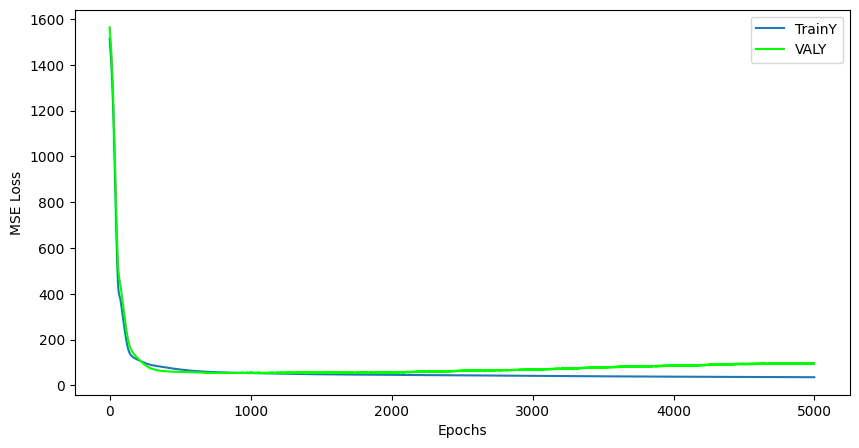

In [104]:
print(f"\nFinal: Loss: {best_val[-1]}")
plot_train_val(loss_train,loss_val)


c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


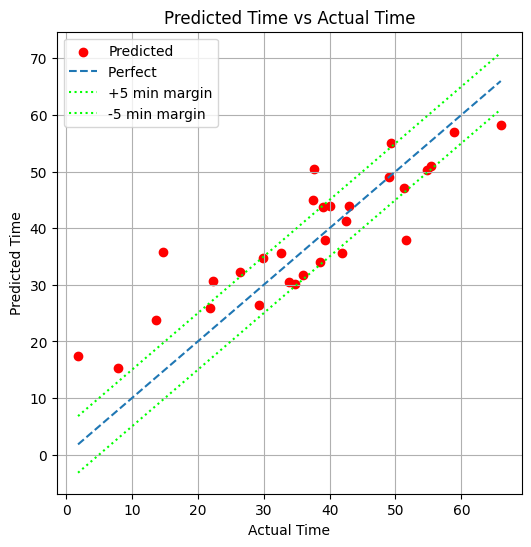

In [105]:
plot_prediction_band(time_val , predictions)

## SVR

In [106]:
syn_customer_train_reg, syn_customer_val_reg, syn_time_train_reg, syn_time_val_reg = train_test_split(syn_costumer_array, syn_time_array, test_size=0.2, random_state=42)

In [107]:
def svr_regression(syn_customer_train_reg,syn_time_train_reg, kernal = "rbf",C=1.0, epsilon=1, gamma='scale'):
    svr = SVR(kernel=kernal, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(syn_customer_train_reg, syn_time_train_reg)
    
    return svr

In [108]:
def success_rate_nparray(time_pred,time_real,error_allowed=5):

    time_pred = np.squeeze(time_pred)         # squeeze because sometimes our array become (n,1) which crashes the code          
    time_real = np.squeeze(time_real)

    differences = np.abs(time_pred - time_real)
    success_count = np.sum(differences <= error_allowed)
    total = len(time_real)
    success_rate = success_count / total * 100

    return success_rate,success_count,total

### HyperParameter tuning

In [109]:
syn_customer_train_reg, syn_customer_val_reg, syn_time_train_reg, syn_time_val_reg = train_test_split(syn_costumer_array, syn_time_array, test_size=0.2, random_state=42)

kernel = ['rbf', 'linear','sigmoid']          # Since 'poly' is heavy :\
C = [0.1, 1, 10, 100,1000]
epsilon= [0.5 ,1, 3,5]
gamma = ['scale', 'auto', 0.1, 1, 0.01]


best_success = 0
best_params = None
best_model_sec = None
best_train_sec = None
best_val_sec = None

param_grid = list(itertools.product(kernel, C, epsilon, gamma))

scalled_customer_train_reg = StandardScaler()                                               #all have the same scale...        
syn_customer_train_reg = scalled_customer_train_reg.fit_transform(syn_customer_train_reg)
syn_customer_val_reg = scalled_customer_train_reg.transform(syn_customer_val_reg)   #same scalling...

for i, (ker, C, epsilon, gamma) in enumerate(tqdm(param_grid, total=len(param_grid), desc="Grid Search")):

    curr_model = svr_regression(syn_customer_train_reg,syn_time_train_reg,ker,C, epsilon,gamma)

    pred_train = curr_model.predict(syn_customer_train_reg)
    mse_train = mean_squared_error(syn_time_train_reg, pred_train)

    predictions = curr_model.predict(syn_customer_val_reg)  # n_samples
    mse_val = mean_squared_error(syn_time_val_reg, predictions)

    success_rate,success_count,total = success_rate_nparray(predictions,syn_time_val_reg)

  
    #print(f"{i} : Training with ker={ker}, CC={CC}, gamma={gamma}, epsilon={epsilon} ---> Success: {best_success:.2f}")
    if best_success < success_rate : 
        best_success = success_rate
        best_params = {'kernel': ker, 'C': C, 'epsilon': epsilon, 'gamma' : gamma}
        best_model_third = copy.deepcopy(curr_model)
        best_train_third = mse_train
        best_val_third = mse_val


print(f"\nBest success: {best_success:.4f} with params: {best_params}")
print(f"Train loss: {best_train_third}, Val loss: {best_val_third}")

Grid Search: 100%|██████████| 300/300 [00:23<00:00, 12.75it/s]


Best success: 31.5000 with params: {'kernel': 'rbf', 'C': 10, 'epsilon': 0.5, 'gamma': 0.01}
Train loss: 144.39872307219076, Val loss: 149.0166563291222


In [125]:
model = svr_regression(customer_train_reg,time_train_reg,
                       kernal='rbf',
                       C=1000,
                       epsilon = 1,
                       gamma = 0.1)

In [126]:
predictions = model.predict(customer_val_reg)  # n_samples

pred_train = model.predict(customer_train_reg)
loss_train = mean_squared_error(time_train_reg, pred_train)

predictions = model.predict(customer_val_reg)  # n_samples
loss_val = mean_squared_error(time_val_reg, predictions)
success_rate,success_count,total = success_rate_nparray(predictions,time_val_reg)

print(f"\n Success ±5 sec: {success_rate:.2f}% ({success_count}/{30}) , MSE val loss : {loss_val} , train mse loss: {loss_train}")


 Success ±5 sec: 53.33% (16/30) , MSE val loss : 68.48387901101441 , train mse loss: 1.7717654679858785


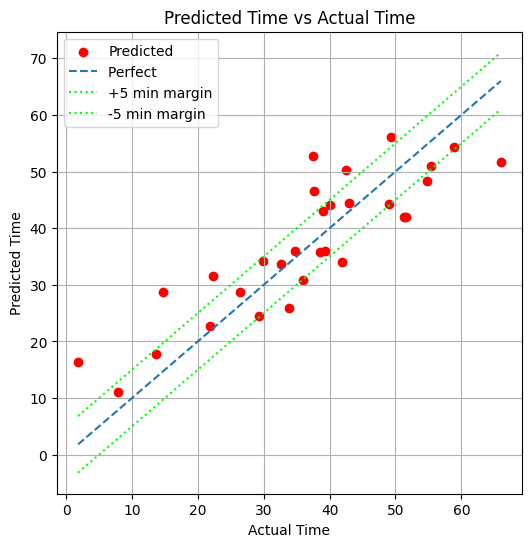

In [ ]:
plot_prediction_band(time_val_reg , predictions)

## Linear Regression

In [132]:
syn_customer_train_reg, syn_customer_val_reg, syn_time_train_reg, syn_time_val_reg = train_test_split(syn_costumer_array, syn_time_array, test_size=0.2, random_state=42)

print(type(syn_customer_train_reg),type(time_train_reg))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>



 Success ±5 sec: 36.67% (11/30),  MSE:112.01195481465797


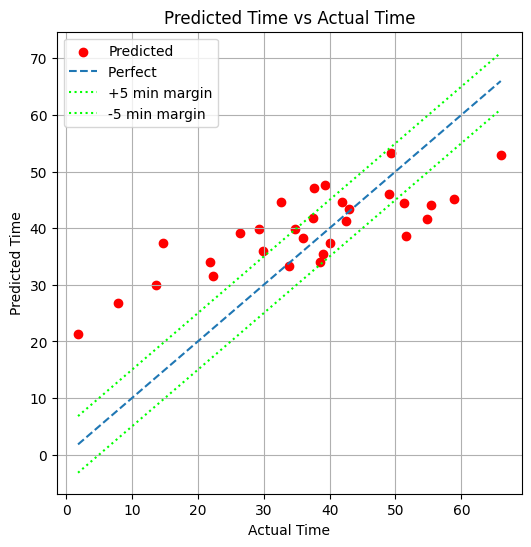

In [133]:
reg = LinearRegression().fit(syn_customer_train_reg,syn_time_train_reg)

time_pred_val = reg.predict(customer_val_reg)

differences = np.abs(time_pred_val - time_val_reg)

success_count = np.sum(differences <= 5)
total = len(time_val_reg)

success_rate = success_count / total * 100

mse = mean_squared_error(time_val_reg, time_pred_val)

print(f"\n Success ±5 sec: {success_rate:.2f}% ({success_count}/{total}),  MSE:{mse}")

plot_prediction_band(time_val_reg,time_pred_val)

---

## Polynomial Regression

In [ ]:
customer_list = []
column_titles = customer_ser.columns.tolist()
for i,title in enumerate(column_titles):

    if i == len(column_titles) - 1:                             
        time_list = customer_ser[title].to_list()
    else:
        customer_list.append(customer_ser[title].to_list())

customer_array = np.array(customer_list).T  # (num_samples, num_features)
time_array= np.array(time_list) 

customer_tensor = torch.tensor(customer_array, dtype=torch.float32)  
time_tensor = torch.tensor(time_list, dtype=torch.float32).view(-1, 1)  # Target 

In [134]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(syn_costumer_array)

# Optional: get the new feature names
feature_names = poly.get_feature_names_out(input_features=column_titles[:-1])
print(feature_names)

['Category' 'Urgency' 'Customer_Type' 'Time_Open_Hour'
 'Previous_Interactions' 'Resolved_By_First_Contact' 'Category^2'
 'Category Urgency' 'Category Customer_Type' 'Category Time_Open_Hour'
 'Category Previous_Interactions' 'Category Resolved_By_First_Contact'
 'Urgency^2' 'Urgency Customer_Type' 'Urgency Time_Open_Hour'
 'Urgency Previous_Interactions' 'Urgency Resolved_By_First_Contact'
 'Customer_Type^2' 'Customer_Type Time_Open_Hour'
 'Customer_Type Previous_Interactions'
 'Customer_Type Resolved_By_First_Contact' 'Time_Open_Hour^2'
 'Time_Open_Hour Previous_Interactions'
 'Time_Open_Hour Resolved_By_First_Contact' 'Previous_Interactions^2'
 'Previous_Interactions Resolved_By_First_Contact'
 'Resolved_By_First_Contact^2']


In [139]:
X_train, X_val, y_train, y_val = train_test_split(X_poly, syn_time_array, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

predictions = reg.predict(X_val)

mse = mean_squared_error(y_val, predictions)
print(f"MSE: {mse:.2f}")

differences = np.abs(predictions - y_val)
success_count = np.sum(differences <= 5)
success_rate = success_count / len(y_val) * 100
print(f"Success ±5 sec: {success_rate:.2f}% ({success_count}/{len(y_val)})")

MSE: 153.58
Success ±5 sec: 27.50% (55/200)


In [ ]:
print(type(poly))


<class 'sklearn.preprocessing._polynomial.PolynomialFeatures'>
